In this notebook, we provide the code for re-training the exact models present in the Sentinel-2 benchmark of the pre-print paper. Alternatively, one can also choose to directly load the available weights of the pre-trained models from the 'Sentinel_model_weigths' folder.

# Imports

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import copy as cp
from time import time
import math

# import torch
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import autograd
import torch.cuda
from torch.func import stack_module_state, vmap, functional_call
import gc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

try :
  print(torch.cuda.get_device_name(0))
except :
  print("No GPU is available.")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def mse_loss(x, x_hat):
    """
    Calculate the Mean Squared Error (MSE) loss between input and reconstructed data.

    Args:
        x (torch.Tensor): Input data.
        x_hat (torch.Tensor): Reconstructed data.

    Returns:
        torch.Tensor: Mean squared error loss.
    """
    total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
    return total_prediction_loss

cuda:0
Tesla T4


In [ ]:
!git clone https://github.com/anthony-frion/AIKAE

from AIKAE.models import KoopmanAE, IKAE, IKAE_zp, AIKAE, NICE, RealNVP

Cloning into 'AIKAE'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 95 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 12.73 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
def rescale(im, minim=None, maxim=None):
    if maxim is None :
      maxim = np.amax(im)
    if minim is None :
      minim = np.amin(im)
    return (im-minim)/(maxim-minim)

In [ ]:
def truncate(im):
  im[im < 0] = 0
  im[im > 1] = 1
  return im

In [ ]:
def mse_loss(x, x_hat):
  total_prediction_loss = torch.sum((x-x_hat)**2)/(x.size()[0])
  return total_prediction_loss

# Import data with gdown

In [ ]:
# Fontainebleau interpolated time series
!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

# Orléans irregular time series and its mask
!gdown 1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710 -O Orléans_irregular.npy
!gdown 17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF -O Orléans_mask.npy

Downloading...
From (original): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo
From (redirected): https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo&confirm=t&uuid=c2cc4e0b-4bec-43ea-bb55-2b36b0736d2a
To: /content/Fontainebleau_interpolated.npy
100% 3.43G/3.43G [00:55<00:00, 61.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710
From (redirected): https://drive.google.com/uc?id=1K2QtxcJjnzCpPgBQnXrTyAM_yoyi2710&confirm=t&uuid=ae05dfe8-61fe-4917-8d9c-56dcc496cc5f
To: /content/Orléans_irregular.npy
100% 3.43G/3.43G [00:52<00:00, 66.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=17IjvRhWT4dzyr9vlKQOjoolYAzTvLfvF
To: /content/Orléans_mask.npy
100% 2.87k/2.87k [00:00<00:00, 16.8MB/s]


Running the cell below enables you to download the Sentinel-2 data directly from Google Drive. Another option is to download the files from https://drive.google.com/drive/u/1/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH and then use it as will, either locally or on a Google Colab session.

In [ ]:
data = np.load('drive/MyDrive/Thèse_Anthony/Sentinel-2/Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)

In [ ]:
# We rescale the data to values between 0 and 1
if np.max(data) > 1:
  data /= max_Fontainebleau
  data *= 3 # Arbitrary rescaling and thresholding since the max is highly saturated
  data[data > 1] = 1

In [ ]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [ ]:
data_test = np.load('Orléans_irregular.npy')
mask_test = np.load('Orléans_mask.npy')

In [ ]:
# We rescale the data to values between 0 and 1
if np.max(data_test) > 3:
  data_test /= max_Fontainebleau
  data_test *= 3 # Arbitrary rescaling since the max is highly saturated
  # This time we do not impose a threshold of 1

In [ ]:
# We extract 150x150 squares out of the 500x500 pixel time series

data_small = data[:,:,250:400,250:400].transpose(0,2,3,1) #150x150
reflectances = data_small.transpose(3,1,2,0)

data_test_small = data_test[:,:,150:300,150:300].transpose(0,2,3,1) #150x150
print(data_test_small.shape)
reflectances_test = data_test_small.transpose(3,1,2,0)

(343, 150, 150, 10)


# Set path for saving models

In [ ]:
# Path for saving the trained models. You can set this path to whatever suitable value.
path = ''
if os.path.exists(path):
  models_path = path
else:
  models_path = ''

# Data preprocessing

Here, we pre-process the data to a format that is suitable for training the models. We randomly extract slices of length 100 (i.e. one year and a half since one time step is 5 days) corresponding to random pixels and initial times. The RNG seed is manually set so that you can get the same results as in the paper.


In [ ]:
time_span = 100
data_small_train = data[:,:,250:400,250:400].transpose(0,2,3,1) #150x150 -> TSP benchmark
#data_small_train = data.transpose(0,2,3,1) # 500x500
reflectances = data_small_train.transpose(3,1,2,0)
L = 10
forward = True
batch_size = 512 # TSP benchmark
nb_batches = 512
#batch_size = 2048 # 16x more data
#nb_batches = 2048

# We set a manual seed for the RNG so that the results
rng = torch.Generator().manual_seed(42)

initial_times = torch.randint(1, 341 - 2*time_span, (batch_size, nb_batches), generator=rng)

initial_x = torch.randint(0, reflectances.shape[1], (batch_size, nb_batches), generator=rng)
initial_y = torch.randint(0, reflectances.shape[1], (batch_size, nb_batches), generator=rng)

initial_state = torch.Tensor(reflectances[:,initial_x,initial_y,initial_times])
initial_state = torch.cat((initial_state,
                            torch.Tensor(reflectances[:,initial_x,initial_y,initial_times]
                                        - reflectances[:,initial_x,initial_y,initial_times-1]))).T
print(f"Shape of initial_state : {initial_state.shape}")

state_batches = torch.zeros((time_span+1, nb_batches, batch_size, 20))
for t in range(time_span+1) :
  state_batches[t] = torch.cat((torch.Tensor(reflectances[:,initial_x,initial_y,initial_times+t]),
                    torch.Tensor(reflectances[:,initial_x,initial_y,initial_times+t]
                                  - reflectances[:,initial_x,initial_y,initial_times+t-1]))).permute((2,1,0))

print(f"Shape of states : {state_batches.shape}")

<ipython-input-14-c374176a773b>:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  - reflectances[:,initial_x,initial_y,initial_times-1]))).T


Shape of initial_state : torch.Size([512, 512, 20])
Shape of states : torch.Size([101, 512, 512, 20])


In [ ]:
initial_x = torch.randint(0, reflectances.shape[1], (batch_size,), generator=rng)
initial_y = torch.randint(0, reflectances.shape[1], (batch_size,), generator=rng)
initial_time = 341 - time_span
initial_state_val = torch.Tensor(reflectances[:,initial_x,initial_y, initial_time]).to(device)
initial_state_val = torch.cat((initial_state_val,
                            torch.Tensor(reflectances[:,initial_x,initial_y,initial_time]
                                        - reflectances[:,initial_x,initial_y,initial_time-1]).cuda())).T
print(f"Shape of initial_state : {initial_state_val.shape}")

states_val = torch.zeros((time_span+1, batch_size, 20)).to(device)
for t in range(time_span+1) :
  states_val[t] = torch.cat((torch.Tensor(reflectances[:,initial_x,initial_y,initial_time+t]).cuda(),
                    torch.Tensor(reflectances[:,initial_x,initial_y,initial_time+t]
                                  - reflectances[:,initial_x,initial_y,initial_time+t-1]).cuda())).T
print(f"Shape of states : {states_val.shape}")


Shape of initial_state : torch.Size([512, 20])
Shape of states : torch.Size([101, 512, 20])


In [ ]:
print(state_batches.shape)

torch.Size([101, 512, 512, 20])


Text(0, 0.5, 'Spectral band')

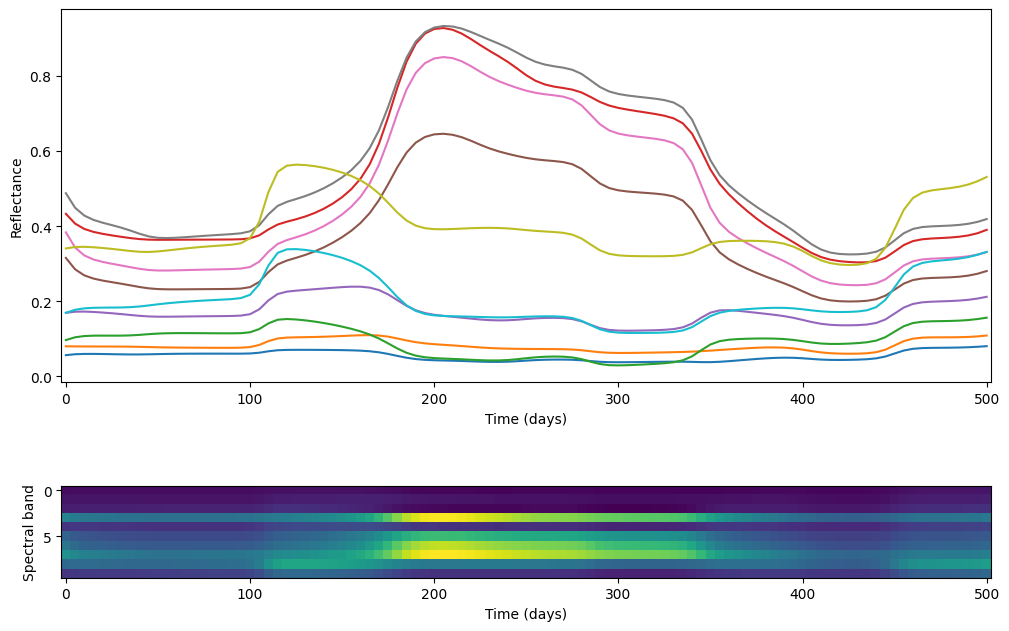

In [ ]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(12,8))
#plt.figure()
gs = gridspec.GridSpec(2,1,height_ratios=[2,1])
plt.subplot(gs[0])
plt.plot([5*k for k in range(state_batches.shape[0])], state_batches[:,42,42,:10].cpu().detach().numpy())
plt.xlim(-2.5, 5*state_batches.shape[0]-2.5)
plt.xlabel('Time (days)')
plt.ylabel('Reflectance')
plt.subplot(gs[1])
plt.imshow(state_batches[:,42,42,:10].T.cpu().detach().numpy())
x = [0, 100, 200, 300, 400, 500]
xi = [k // 5 for k in x]
plt.xticks(xi, x)
plt.xlabel('Time (days)')
plt.ylabel('Spectral band')

# KAE

In [ ]:
torch.manual_seed(0)
model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)

print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 300596
KoopmanAE(
  (encoder): ModuleList(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=20, bias=True)
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = KoopmanAE.KoopmanAE(20, [512,256,32], device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  opt = model.configure_optimizers(lr=1e-3)
  #opt = model.configure_optimizers(lr=1e-3, weight_decay=1e-6) # With weight decay
  max_patience = 50
  patience = 0
  time_span = 100
  alpha = 0
  lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt)
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, latent_states.shape, gt.shape)
      loss += model.mse_loss(model.decode(phis), gt)
      # Reconstruction loss
      loss += model.mse_loss(model.decode(latent_states), gt)
      # Linearity loss
      loss += model.mse_loss(phis, latent_states)
      # Orthogonality loss
      loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()
    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    loss = 0
    # Prediction loss
    val_loss += model.mse_loss(model.decode(phis), gt)
    # Reconstruction loss
    val_loss += model.mse_loss(model.decode(latent_states), gt)
    # Linearity loss
    val_loss += model.mse_loss(phis, latent_states)
    # Orthogonality loss
    val_loss += lamda * model.mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()

    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis)
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'best_model_{seed}.pt')
      torch.save(model.K, models_path+f'best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1

Training model with seed 0
Epoch 1 : Train loss 42.29852713085711, validation loss 16.657142639160156
Complete prediction MSE : 0.0033415014728621177
Saving model
Epoch 2 : Train loss 13.218219744041562, validation loss 10.151602745056152
Complete prediction MSE : 0.0030637703789057305
Saving model
Epoch 3 : Train loss 11.161183092743158, validation loss 9.764592170715332
Complete prediction MSE : 0.003106205448436413
Epoch 4 : Train loss 10.001219255849719, validation loss 8.573482513427734
Complete prediction MSE : 0.0030965341656651454
Epoch 5 : Train loss 9.306296849623322, validation loss 8.282848358154297
Complete prediction MSE : 0.002745189062960039
Saving model
Epoch 6 : Train loss 8.854835169389844, validation loss 8.796456336975098
Complete prediction MSE : 0.002670479171592385
Saving model
Epoch 7 : Train loss 8.477220820263028, validation loss 9.631791114807129
Complete prediction MSE : 0.0026483069546195622
Saving model
Epoch 8 : Train loss 8.128242121078074, validation l

KeyboardInterrupt: 

# IKAE

In [ ]:
model = IKAE.IKAE(input_dim=20, hidden_dim=512, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='RNVP', device=device).to(device)

In [ ]:
torch.manual_seed(0)
model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 32316
IKAE(
  (positive_nonlin): Softplus(beta=1.0, threshold=20.0)
  (invertible_encoder): stacked_NICE(
    (bijectors): ModuleList(
      (0-5): 6 x NICE(
        (net): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=10, bias=True)
        )
      )
    )
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = IKAE.IKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  opt = model.configure_optimizers(lr=1e-3)
  #opt = model.configure_optimizers(lr=1e-3, weight_decay=1e-6) # With weight decay
  max_patience = 50
  patience = 0
  time_span = 100
  alpha = 0
  lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement and/or unstable training')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt.flatten(0,1))
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, latent_states.shape, gt.shape)
      pred_loss = mse_loss(model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], phis.shape[2])), gt)
      loss += pred_loss
      # Reconstruction loss
      #ae_loss = mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
      #loss += ae_loss
      # Linearity loss
      lin_loss = mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
      loss += lin_loss
      # Orthogonality loss
      orth_loss = lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
      loss += orth_loss
      #if batch % 100 == 0:
        #print(f"Batch {batch}: loss = {loss}")
        #print(f"pred loss = {pred_loss}, ae loss = {ae_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
        #print(f"pred loss = {pred_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()

    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device).flatten(0,1))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    # Prediction loss
    val_loss += mse_loss(model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], phis.shape[2])), gt)
    # Reconstruction loss
    #val_loss += mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
    # Linearity loss
    val_loss += mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
    # Orthogonality loss
    val_loss += lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()
    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], phis.shape[2]))
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'best_model_{seed}.pt')
      torch.save(model.K, models_path+f'best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1
      if math.isnan(epoch_val_loss) or model.train_losses[-1] > 1000:
        patience += 10

Training model with seed 0
Epoch 1 : Train loss 37.014617839828134, validation loss 20.245361328125
Complete prediction MSE : 0.0037657297953353577
Saving model
Epoch 2 : Train loss 16.711873963475227, validation loss 19.921512603759766
Complete prediction MSE : 0.004068091678733972
Epoch 3 : Train loss 14.605594091117382, validation loss 13.90436840057373
Complete prediction MSE : 0.0032485510468282888
Saving model
Epoch 4 : Train loss 14.230510007590055, validation loss 10.763667106628418
Complete prediction MSE : 0.0026631838362406444
Saving model
Epoch 5 : Train loss 12.813452452421188, validation loss 9.88741683959961
Complete prediction MSE : 0.002544638098104507
Saving model
Epoch 6 : Train loss 12.193345600739121, validation loss 9.983470916748047
Complete prediction MSE : 0.003826228240275347
Epoch 7 : Train loss 12.126866331323981, validation loss 10.23216724395752
Complete prediction MSE : 0.0026522661456572735
Epoch 8 : Train loss 11.963246000930667, validation loss 9.41088

KeyboardInterrupt: 

# IKAE-zp

In [ ]:
torch.manual_seed(0)
model = IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16,
                   positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)

print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 56940
IKAE(
  (positive_nonlin): Softplus(beta=1.0, threshold=20.0)
  (invertible_encoder): stacked_NICE(
    (bijectors): ModuleList(
      (0-5): 6 x NICE(
        (net): Sequential(
          (0): Linear(in_features=18, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=18, bias=True)
        )
      )
    )
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = IKAE_zp(input_dim=20, hidden_dim=256, n_layers_encoder=6, zero_padding=16,
                     positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  #opt = model.configure_optimizers(lr=1e-3)
  opt = model.configure_optimizers(lr=1e-3, weight_decay=1e-6) # with weight decay
  max_patience = 50
  patience = 0
  time_span = 100
  alpha = 0
  lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement and/or unstable training')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt.flatten(0,1))
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, latent_states.shape, gt.shape)
      pred_loss = mse_loss(model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], model.input_dim)), gt)
      loss += pred_loss
      # Reconstruction loss
      #ae_loss = mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
      #loss += ae_loss
      # Linearity loss
      lin_loss = mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
      loss += lin_loss
      # Orthogonality loss
      orth_loss = lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
      loss += orth_loss
      #if batch % 100 == 0:
        #print(f"Batch {batch}: loss = {loss}")
        #print(f"pred loss = {pred_loss}, ae loss = {ae_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
        #print(f"pred loss = {pred_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()

    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device).flatten(0,1))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    # Prediction loss
    val_loss += mse_loss(model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], model.input_dim)), gt)
    # Reconstruction loss
    #val_loss += mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
    # Linearity loss
    val_loss += mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
    # Orthogonality loss
    val_loss += lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()
    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], model.input_dim))
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'/best_model_{seed}.pt')
      torch.save(model.K, models_path+f'/best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1
      if math.isnan(epoch_val_loss) or model.train_losses[-1] > 1000:
        patience += 10

Training model with seed 0
Epoch 1 : Train loss 40.90683432482183, validation loss 19.194581985473633
Complete prediction MSE : 0.004046380256563871
Saving model
Epoch 2 : Train loss 15.730235120281577, validation loss 21.397802352905273
Complete prediction MSE : 0.004166098449029065
Epoch 3 : Train loss 13.483702862635255, validation loss 11.893830299377441
Complete prediction MSE : 0.002712641375348511
Saving model
Epoch 4 : Train loss 12.536097005009651, validation loss 15.259390830993652
Complete prediction MSE : 0.0037292211096682276
Epoch 5 : Train loss 11.34023954346776, validation loss 12.03137493133545
Complete prediction MSE : 0.0029895456343050166
Epoch 6 : Train loss 10.700973888859153, validation loss 9.807804107666016
Complete prediction MSE : 0.0025839907017764607
Saving model
Epoch 7 : Train loss 10.19399026595056, validation loss 9.25197982788086
Complete prediction MSE : 0.002692544856376165
Epoch 8 : Train loss 10.208275001496077, validation loss 10.13748836517334
Co

# AIKAE

In [ ]:
torch.manual_seed(0)
model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16],
                    positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
print(f"Number of parameters: {count_parameters(model)}")
print(model)

Number of parameters: 313932
AIKAE(
  (positive_nonlin): Softplus(beta=1.0, threshold=20.0)
  (invertible_encoder): stacked_NICE(
    (bijectors): ModuleList(
      (0-5): 6 x NICE(
        (net): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=10, bias=True)
        )
      )
    )
  )
  (augmentation_encoder): ModuleList(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=16, bias=True)
  )
)


In [ ]:
nb_seeds = 5
for seed in range(nb_seeds):
  torch.manual_seed(seed)
  model = AIKAE.AIKAE(input_dim=20, hidden_dim=256, n_layers_encoder=6, augmentation_dims=[512,512,16],
                      positive_nonlin=nn.Softplus(), flow='NICE', device=device).to(device)
  print(f'Training model with seed {seed}')
  epochs = 500
  #opt = model.configure_optimizers(lr=1e-3)
  opt = model.configure_optimizers(lr=1e-3, weight_decay=1e-6) #with weight decay
  max_patience = 50
  patience = 0
  time_span = 100
  alpha = 0
  lamda = 100.
  model.best_epoch, model.best_val = 0, 1e15
  last_train_index = 53
  model.train_losses = []
  model.val_losses = []
  model.val_losses2 = []
  model.val_losses3 = []
  starting_point = 0
  loss_every = 1

  for epoch in range(epochs+1) :
    if patience >= max_patience:
      print('Early stopping due to no more improvement and/or unstable training')
      break
    epoch_loss = 0
    epoch_val_loss = 0
    model.train()
    for batch in range(nb_batches) :
      opt.zero_grad()
      x0 = state_batches[0,batch].to(device)
      gt = state_batches[:,batch].to(device)
      latent_states = model.encode(gt.flatten(0,1))
      #print(gt.shape, latent_states.shape, x0.shape)
      xt, phis = model.forward_n_remember(x0, time_span)
      phi_0 = phis[0]
      loss = 0
      # Prediction loss
      #print(phis.shape, latent_states.shape, gt.shape)
      pred_loss = mse_loss(model.decode(phis.flatten(0,1)).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
      loss += pred_loss
      # Reconstruction loss
      #ae_loss = mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
      #loss += ae_loss
      # Linearity loss
      lin_loss = mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
      loss += lin_loss
      # Orthogonality loss
      orth_loss = lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
      loss += orth_loss
      #if batch % 100 == 0:
        #print(f"Batch {batch}: loss = {loss}")
        #print(f"pred loss = {pred_loss}, ae loss = {ae_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
        #print(f"pred loss = {pred_loss}, lin loss = {lin_loss}, orth loss = {orth_loss}")
      loss.backward()
      opt.step()
      epoch_loss += loss.detach().item()

    #scheduler.step()
    epoch_loss /= nb_batches
    model.train_losses.append(epoch_loss)
    model.eval()
    val_loss = 0
    x0 = states_val[0].to(device)
    gt = states_val.to(device)
    latent_states = model.encode(states_val.to(device).flatten(0,1))
    xt, phis = model.forward_n_remember(x0, time_span)
    phi_0 = phis[0]
    loss = 0
    # Prediction loss
    val_loss += mse_loss(model.decode(phis.flatten(0,1)).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
    # Reconstruction loss
    #val_loss += mse_loss(model.decode(latent_states).reshape((gt.shape[0], gt.shape[1], gt.shape[2])), gt)
    # Linearity loss
    val_loss += mse_loss(phis, latent_states.reshape((phis.shape[0], phis.shape[1], phis.shape[2])))
    # Orthogonality loss
    val_loss += lamda * mse_loss(torch.matmul(model.K, model.K.T), torch.eye(model.latent_dim).to(device)) * batch_size / 512
    model.val_losses2.append(val_loss.item())
    #epoch_val_loss = val_loss.item()
    whole_predictions = np.zeros((data_small.shape[0]-101, data_small.shape[1]//10, data_small.shape[2], data_small.shape[3]))
    for column in range(data_small.shape[1] // 10) :
      states = torch.Tensor(data_small[1:,10*column]).to(device)
      states = torch.cat([states, states - torch.Tensor(data_small[:-1,10*column]).to(device)], dim=2) # Add derivatives
      predictions, phis = model.forward_n_remember(states[starting_point],241)
      #whole_predictions[starting_point:, column] = predictions[:342-starting_point,:10].cpu().detach()
      decoded = model.decode(phis.flatten(0,1)).reshape((phis.shape[0], phis.shape[1], model.input_dim))
      whole_predictions[starting_point:, column] = decoded[:whole_predictions.shape[0]-starting_point,:,:10].cpu().detach()

    val_loss3 = np.mean((data_small[starting_point+1:starting_point+243,::10] - whole_predictions)[starting_point:] **2)
    model.val_losses3.append(val_loss3.item())
    epoch_val_loss = val_loss3.item()
    if epoch % loss_every == 0 :
      print(f"Epoch {epoch+1} : Train loss {model.train_losses[-1]}, validation loss {model.val_losses2[-1]}")
      print(f"Complete prediction MSE : {model.val_losses3[-1]}")
    if epoch_val_loss < model.best_val : # Save the model parameters
      model.best_val = epoch_val_loss
      model.best_epoch = epoch
      torch.save(model.state_dict(), models_path+f'/best_model_{seed}.pt')
      torch.save(model.K, models_path+f'/best_K_{seed}.pt')
      patience = 0
      print('Saving model')
    else:
      patience += 1
      if math.isnan(epoch_val_loss) or model.train_losses[-1] > 1000:
        patience += 10

Training model with seed 0
Epoch 1 : Train loss 36.87611767090857, validation loss 25.111949920654297
Complete prediction MSE : 0.003936433346558266
Saving model
Epoch 2 : Train loss 15.018192157149315, validation loss 10.20786190032959
Complete prediction MSE : 0.0028764619538148547
Saving model
Epoch 3 : Train loss 28.60874625481665, validation loss 15.317610740661621
Complete prediction MSE : 0.0027090137547301006
Saving model
Epoch 4 : Train loss 13.81826752051711, validation loss 12.338517189025879
Complete prediction MSE : 0.0028295211987149544
Epoch 5 : Train loss 12.042797798290849, validation loss 10.628305435180664
Complete prediction MSE : 0.0027449839010663113
Epoch 6 : Train loss 10.907390741631389, validation loss 10.139772415161133
Complete prediction MSE : 0.0026205659019569996
Saving model
Epoch 7 : Train loss 24.967963559553027, validation loss 14.899036407470703
Complete prediction MSE : 0.0028323561367534916
Epoch 8 : Train loss 13.26255633495748, validation loss 12